In [18]:
# !pip install stim~=1.11
# !pip install pymatching~=2.0
# !pip install sinter~=1.10

In [19]:
import stim
import pymatching
import sinter
import matplotlib.pyplot as plt
import json
from typing import Callable

In [20]:
def gen_stim_circuit(roundNum, result, distance, noise):
    chunkNum = result['chunkNum']
    Stab = result['Stab']
    Data = result['Data']
    Circuit = result['Circuit']
    Swap_layer = result['Swap_layer']
    idx2coord = result['idx2coord']
    physNum = len(idx2coord)

    after_clifford_depolarization1, after_clifford_depolarization2, after_reset_flip_probability, before_measure_flip_probability, before_round_data_depolarization, idle_error = noise

    circstr = ''
    meas_list = []

    TARGET : Callable[[list], str] = lambda qlist: "".join([' %d' % q for q in qlist])

    # reset
    R : Callable[[list], str]  = lambda qlist: 'R' + TARGET(qlist) + '\n'
    # H gate
    H : Callable[[list], str]  = lambda qlist: 'H' + TARGET(qlist) + '\n'
    # CX gate
    CX : Callable[[list], str]  = lambda qlist: 'CX' + TARGET(qlist) + '\n'
    # CZ gate
    CZ : Callable[[list], str]  = lambda qlist: 'CZ' + TARGET(qlist) + '\n'
    # SWAP gate
    SWAP : Callable[[list], str]  = lambda qlist: 'SWAP' + TARGET(qlist) + '\n'
    # Meaurement
    M : Callable[[list], str]  = lambda qlist: 'M' + TARGET(qlist) + '\n'
    MR : Callable[[list], str]  = lambda qlist: 'MR' + TARGET(qlist) + '\n'

    # X errors
    X_ERROR : Callable[[float, list], str] = lambda error_rate, qlist: ('X_ERROR(%lf)' % (error_rate) + TARGET(qlist) + '\n') if error_rate else ''
    # single qubit depolarize error
    DEPOLARIZE1 : Callable[[float, list], str] = lambda error_rate, qlist: ('DEPOLARIZE1(%lf)' % (error_rate) + TARGET(qlist) + '\n') if error_rate else ''
    # two qubit depolarize error
    DEPOLARIZE2 : Callable[[float, list], str] = lambda error_rate, qlist: ('DEPOLARIZE2(%lf)' % (error_rate) + TARGET(qlist) + '\n') if error_rate else ''

    # measurement list
    M1 = lambda value: max(loc for loc, flag in enumerate(meas_list) if flag == value) - len(meas_list)
    M2 = lambda value: max([loc for loc, flag in enumerate(meas_list) if flag == value][:-1]) - len(meas_list)

    # Coordinates   
    for k, (i, j) in enumerate(idx2coord):
        circstr += "QUBIT_COORDS(%d, %d) %d\n" % (i, j, k)

    # Reset data qubits:
    circstr += R(Data[0])
    circstr += X_ERROR(after_reset_flip_probability, Data[0])

    # Initial phase:
    circstr += DEPOLARIZE1(before_round_data_depolarization, Data[0])
    for chunkNo in range(chunkNum):
        stab = Stab[chunkNo]
        circuit = Circuit[chunkNo]
        swap_layer = Swap_layer[chunkNo]

        cur_t = 0
        R_list = []
        H_list = []
        CX_list = []
        CZ_list = []
        idle_list = [1 for _ in range(physNum)]

        for t, circ in circuit:
            if t != cur_t:
                if R_list:
                    circstr += R(R_list)
                    circstr += X_ERROR(after_reset_flip_probability, R_list)
                if H_list:
                    circstr += H(H_list)
                    circstr += DEPOLARIZE1(after_clifford_depolarization1, H_list)
                if CX_list:
                    circstr += CX(CX_list)
                    circstr += DEPOLARIZE2(after_clifford_depolarization2, CX_list)
                if CZ_list:
                    circstr += CZ(CZ_list)
                    circstr += DEPOLARIZE2(after_clifford_depolarization2, CZ_list)

                for i in range(physNum):
                    if idle_list[i]:
                        circstr += DEPOLARIZE1(idle_error, [i])

                cur_t = t
                R_list = []
                H_list = []
                CX_list = []
                CZ_list = []
                idle_list = [1 for _ in range(physNum)]
                circstr += 'TICK\n'
                
            if circ[0] == 'reset':
                R_list.append(circ[1])
                idle_list[circ[1]] = 0
            elif circ[0] == 'H':
                H_list.append(circ[1])
                idle_list[circ[1]] = 0
            elif circ[0] == 'X':
                CX_list.extend(circ[1:3])
                idle_list[circ[1]] = 0
                idle_list[circ[2]] = 0
            elif circ[0] == 'Z':
                CZ_list.extend(circ[1:3])
                idle_list[circ[1]] = 0
                idle_list[circ[2]] = 0
            elif circ[0] == 'Mz':
                idle_list[circ[2]] = 0

                stabNo = circ[1]
                physNo = circ[2]

                target = [physNo]
                i, j = idx2coord[physNo]

                circstr += X_ERROR(before_measure_flip_probability, target)
                circstr += M(target)

                flag = (chunkNo, stabNo, physNo)
                meas_list.append(flag)

                if stab[stabNo]['Ctrl'][0][2][0]!='X' or stab[stabNo]['synd']!=physNo:
                    circstr += "DETECTOR(%d, %d, 0) rec[-1] \n" % (i, j)
        
        for _, circ in swap_layer:
            target = [circ[1], circ[2]]
            circstr += SWAP(target)
            circstr += DEPOLARIZE2(after_clifford_depolarization2, target)

    # Repeat phase:
    if roundNum-1 > 0:
        circstr += "REPEAT %d { \n" % (roundNum-1)
        circstr += DEPOLARIZE1(before_round_data_depolarization, Data[0])
        circstr += "SHIFT_COORDS(%d, %d, %d) \n" % (0, 0, 1)

        for chunkNo in range(chunkNum):
            stab = Stab[chunkNo]
            circuit = Circuit[chunkNo]
            swap_layer = Swap_layer[chunkNo]

            cur_t = 0
            R_list = []
            H_list = []
            CX_list = []
            CZ_list = []
            idle_list = [1 for _ in range(physNum)]

            for t, circ in circuit:
                if t != cur_t:
                    if R_list:
                        circstr += R(R_list)
                        circstr += X_ERROR(after_reset_flip_probability, R_list)
                    if H_list:
                        circstr += H(H_list)
                        circstr += DEPOLARIZE1(after_clifford_depolarization1, H_list)
                    if CX_list:
                        circstr += CX(CX_list)
                        circstr += DEPOLARIZE2(after_clifford_depolarization2, CX_list)
                    if CZ_list:
                        circstr += CZ(CZ_list)
                        circstr += DEPOLARIZE2(after_clifford_depolarization2, CZ_list)

                    for i in range(physNum):
                        if idle_list[i]:
                            circstr += DEPOLARIZE1(idle_error, [i])

                    cur_t = t
                    R_list = []
                    H_list = []
                    CX_list = []
                    CZ_list = []
                    idle_list = [1 for _ in range(physNum)]
                    circstr += 'TICK\n'
                    
                if circ[0] == 'reset':
                    R_list.append(circ[1])
                    idle_list[circ[1]] = 0
                elif circ[0] == 'H':
                    H_list.append(circ[1])
                    idle_list[circ[1]] = 0
                elif circ[0] == 'X':
                    CX_list.extend(circ[1:3])
                    idle_list[circ[1]] = 0
                    idle_list[circ[2]] = 0
                elif circ[0] == 'Z':
                    CZ_list.extend(circ[1:3])
                    idle_list[circ[1]] = 0
                    idle_list[circ[2]] = 0
                elif circ[0] == 'Mz':
                    stabNo = circ[1]
                    physNo = circ[2]

                    target = [physNo]
                    i, j = idx2coord[physNo]

                    circstr += X_ERROR(before_measure_flip_probability, target)
                    circstr += M(target)

                    flag = (chunkNo, stabNo, physNo)
                    meas_list.append(flag)

                    if stab[stabNo]['synd'] == physNo:
                        circstr += "DETECTOR(%d, %d, 0) rec[-1] rec[%d] \n" % (i, j, M2(flag))
                    else:
                        circstr += "DETECTOR(%d, %d, 0) rec[-1] \n" % (i, j)

            for _, circ in swap_layer:
                target = [circ[1], circ[2]]
                circstr += SWAP(target)
                circstr += DEPOLARIZE2(after_clifford_depolarization2, target)

        circstr += "}\n"
    
    # End phase:
    circstr += X_ERROR(before_measure_flip_probability, Data[0])
    for q in Data[0]:
        circstr += M([q])
        meas_list.append((-1, q))     # -1 for data qubit measure

    for chunkNo in range(chunkNum):
        stab = Stab[chunkNo]

        for stabNo in range(len(stab)):
            stabilizer = stab[stabNo]
            synd = stabilizer['synd']
            i, j = idx2coord[synd]

            if stabilizer['Ctrl'][0][2][0] == 'Z':
                circstr += "DETECTOR(%d, %d, 1) rec[%d]" % (i, j, M1((chunkNo, stabNo, synd)))
                for dataNo in stabilizer['Data']:
                    circstr += " rec[%d]" % M1((-1, Data[0][dataNo]))
                circstr += '\n'


    circstr += "OBSERVABLE_INCLUDE(0)"
    for q in range(distance):
        circstr += " rec[%d]" % M1((-1, Data[0][q]))
    circstr += '\n'

    # print(circstr)

    stimcir = stim.Circuit(circstr)

    # print(repr(stimcir))

    return stimcir

In [21]:
# # load data
# codeName = 'Surface_3'
# archName = 'hexagon_5x5'
# base = codeName + '-' + archName

# with open('../output/S2_'+base+'.json', 'r') as f:
#     result = json.load(f) 

In [22]:
# mine
results = {}
Tasks = [
    (3, 'Surface_3', 'h_square_3x4'),
    (5, 'Surface_5', 'h_square_5x6'),
    # (7, 'Surface_7', 'h_square_7x8')
]

noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
for (d, codeName, archName) in Tasks:
    base = codeName + '-' + archName
    with open('../output/S2_'+base+'.json', 'r') as f:
        results[d] = json.load(f)

from typing import List
tasks = [
    sinter.Task(
        circuit = gen_stim_circuit(
            3 * d, results[d], d, (noise, noise, noise, noise, noise, 0)
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d, _, _ in Tasks
    for noise in noises
]

stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots= 100_000, # 1_000_000,
    max_errors= 50_000, # 1_000_000,
    print_progress=True,
)

Starting 4 workers...


6 cases left:
    pymatching processes=4  ~core_mins_left=1       shots_left=83800    errors_left=49866   {d=5,p=0.002,r=15}
    pymatching processes=0  ~core_mins_left=None    shots_left=100000   errors_left=50000   {d=5,p=0.003,r=15}
4 cases left:
    pymatching processes=1  ~core_mins_left=1       shots_left=39600    errors_left=46764   {d=5,p=0.004,r=15}
    pymatching processes=3  ~core_mins_left=1       shots_left=67600    errors_left=46858   {d=5,p=0.005,r=15}
1 cases left:
    pymatching processes=4  ~core_mins_left=1       shots_left=83800    errors_left=46686   {d=5,p=0.007,r=15}
Done collecting


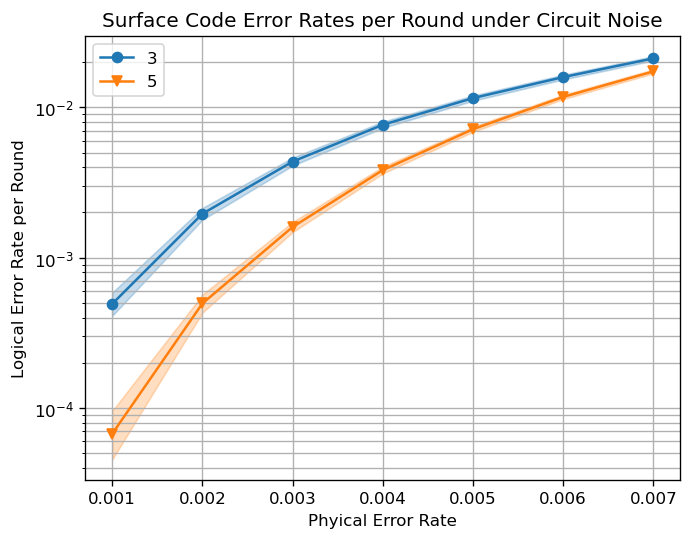

In [23]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
    failure_units_per_shot_func=lambda stats: stats.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.set_yscale('log')
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [24]:
import pickle
with open("SurfStitch_result.pkl", "rb") as f:
    result = pickle.load(f)

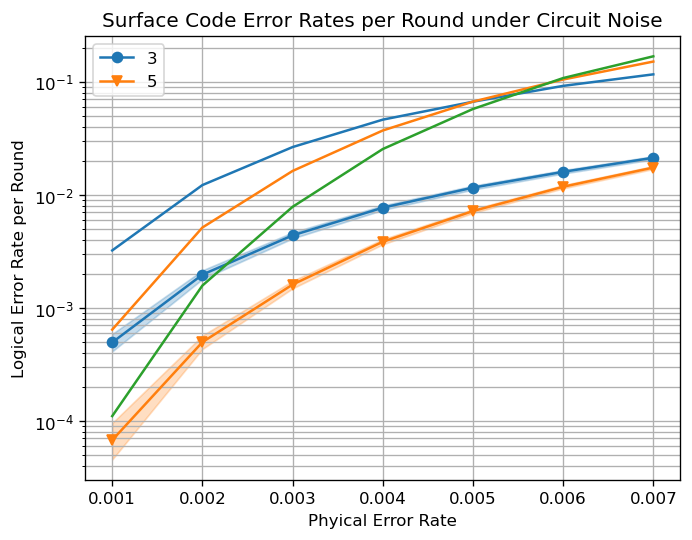

In [25]:
for d, xs, ys in zip(result['d'], result['xss'], result['yss']):
    ax.plot(xs, ys, label="d=" + str(d))
fig